## Supervised Portrait Shadow Identification

A lot of the shadow removal methods, particularly the deep learning methods, take a long time to run. Some take more than a minute for each image.

If a photographer had thousands of portraits, some which didn't have shadows, this could be very inefficient. We propose building a supervised shadow identification model, so only images with shadows can be processed without manual filtering. This model outputs a 1 if the portrait has shadows and a 0 otherwise.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/CIS5810

/content/drive/MyDrive/CIS5810


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np

img_width, img_height = 256, 256

### Load Data

The data we have been working with for this project was not to train a large, deep learning model, it was used to explore the preformance of different shadow removal methods. Thus, we didn't need an extremely large and robust dataset.

This shadow identification model explores a potential solution to an issue we discovered doing our project. We are using the dataset used in previous areas of our project, which only consists of a little more than 100 images. In an ideal situation we would be working with thousands of images, and have enough imagaes to have train, test, and validation data (only using two splits of data in this example). There is also an imbalance with the number of examples from each class, we have more examples of shadows than no shadow images, due to the fact that the same person has many different shadows projected on their face, but only one shadow-free image in the dataset.

In [4]:
train_data_dir = 'shadow_identification_data/Train'
validation_data_dir = 'shadow_identification_data/Test'
nb_train_samples = 93
nb_validation_samples = 18

epochs = 12
batch_size = 8

In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Train

Using the package Keras to build a simple CNN using only CPUs rather than GPUs.

After playing around with the model, the intitial model that was being used was too complex for the size of the data. It tended to overfit the training data, so it was simplified. There are two Convolutional layers, both using ReLU activation and MaxPooling. Finally, the flattened output is run throgh a Sigmoid activation function.

The loss used is binary cross entropy loss and the optimizer is rmsprop. Typically, accuracy is avoided with a class imbalance, but with such a small dataset, we were able to manually check the results to make sure the model was not heavily biased towards the majority class.

Keras uses a data generator to preform different rotations / zooms / shears of the images to create a more robust and larger model. This is really beneficial due to our smaller sample size.

In [6]:
#Model - adjust
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(64))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 93 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


<ipython-input-7-f9208fe55001>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/12
11/11 [==============================] - 26s 2s/step - loss: 0.8728 - accuracy: 0.8235 - val_loss: 0.7429 - val_accuracy: 0.8125
Epoch 2/12
11/11 [==============================] - 8s 760ms/step - loss: 0.2983 - accuracy: 0.9059 - val_loss: 0.7287 - val_accuracy: 0.8125
Epoch 3/12
11/11 [==============================] - 7s 606ms/step - loss: 0.2903 - accuracy: 0.9176 - val_loss: 0.3502 - val_accuracy: 0.9375
Epoch 4/12
11/11 [==============================] - 10s 866ms/step - loss: 0.1785 - accuracy: 0.9205 - val_loss: 0.3171 - val_accuracy: 0.8750
Epoch 5/12
11/11 [==============================] - 7s 588ms/step - loss: 0.2257 - accuracy: 0.8864 - val_loss: 0.4298 - val_accuracy: 0.8750
Epoch 6/12
11/11 [==============================] - 8s 646ms/step - loss: 0.1009 - accuracy: 0.9529 - val_loss: 0.3263 - val_accuracy: 0.9375
Epoch 7/12
11/11 [==============================] - 10s 941ms/step - loss: 0.1177 - accuracy: 0.9647 - val_loss: 0.9803 - val_accuracy: 0.8125
Epoch 

### Test

Here are some outputted images from the test set. We can see that it correctly predicts the first image as having no shadow. But, the second image is predicted to have a shadow in both when there is no shadow and when there is a shadow.

Ultimately, this was an initial exploration into a shadow identification model to reduce computation using shadow removal models. To guarantee a high-preforming model, it would require much more training data than we had access to.

In [10]:
image = load_img('shadow_identification_data/Test/NoShadow/4.png', target_size=(256,256))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,256,256,3)
label = model.predict(img)[0][0]
print("Predicted Class (0 - No Shadow , 1 - Shadow): ", round(label))

1/1 [==============================] - 0s 119ms/step
Predicted Class (0 - No Shadow , 1 - Shadow):  0


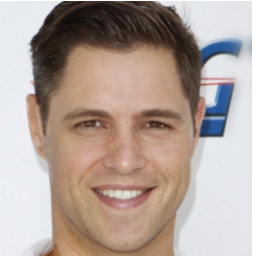

In [11]:
image

In [16]:
image = load_img('shadow_identification_data/Test/NoShadow/8.png', target_size=(256,256))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,256,256,3)
label = model.predict(img)[0][0]
print("Predicted Class (0 - No Shadow , 1 - Shadow): ", round(label))

1/1 [==============================] - 0s 35ms/step
Predicted Class (0 - No Shadow , 1 - Shadow):  1


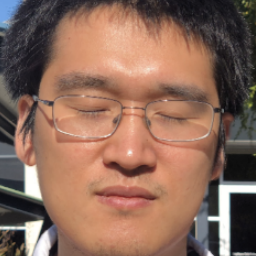

In [17]:
image

In [18]:
image = load_img('shadow_identification_data/Test/Shadow/9162-031.png', target_size=(256,256))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,256,256,3)
label = model.predict(img)[0][0]
print("Predicted Class (0 - No Shadow , 1 - Shadow): ", round(label))

1/1 [==============================] - 0s 54ms/step
Predicted Class (0 - No Shadow , 1 - Shadow):  1


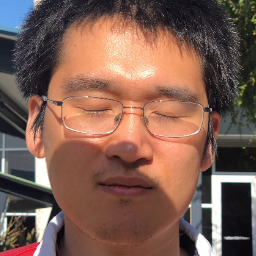

In [19]:
image